In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# This and the next cells are made by me: want to inspect table before proceeding with analysis
from sqlalchemy import inspect

In [10]:
# Inspection 
inspector = inspect(engine)
print("Measurement Columns:")
mea_column = inspector.get_columns("Measurement")
for mea in mea_column:
    print(mea["name"], mea["type"])
print("------")

print("Station Columns:")
stat_column = inspector.get_columns("Station")
for stat in stat_column:
    print(stat["name"], stat["type"])

Measurement Columns:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------
Station Columns:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first() # The most recent date is 2017-08-23

('2017-08-23',)

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
sel = [Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs]
most_recent = session.query(*sel).order_by(Measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.
one_year = dt.date(2017, 8, 23) - dt.timedelta(days=365) # one_year = datetime.date(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp, columns=["Date", "Precipitation"])
prcp_df = prcp_df.set_index("Date")

# Sort the dataframe by date
prcp_df = prcp_df.sort_values("Date", ascending=True) #2230 rows x 1 column

# Clean up the data to exclude null values
prcp_df.dropna(how="any", inplace=True) # 2021 rows x 1 column
prcp_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


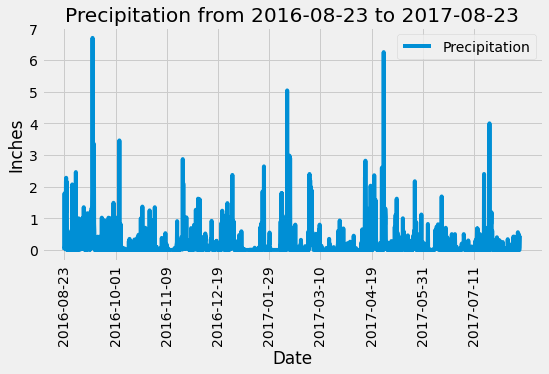

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data

major_tick = np.arange(0,2000,227)
prcp_df.plot(label="Precipitation", ylabel="Inches", xticks=major_tick, use_index=True, figsize=(8,4))
plt.legend()
plt.xticks(rotation=90)
plt.title("Precipitation from 2016-08-23 to 2017-08-23")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_grouped = prcp_df.groupby("Date")

prcp_mean = prcp_grouped["Precipitation"].mean() #366
prcp_median = prcp_grouped["Precipitation"].median()
prcp_var = prcp_grouped["Precipitation"].var()
prcp_stdev = prcp_grouped["Precipitation"].std()
prcp_sem = prcp_grouped["Precipitation"].sem()

prcp_sumstats = pd.DataFrame({"Mean":prcp_mean, "Median":prcp_median, "Variance":prcp_var, 
                              "Standard Deviation":prcp_stdev, "SEM":prcp_sem})
prcp_sumstats.head()

,Mean,Median,Variance,Standard Deviation,SEM
Date,,,,,
2016-08-23,0.451667,0.100,0.499097,0.706468,0.288414
2016-08-24,1.555000,1.800,0.706510,0.840541,0.343150
2016-08-25,0.077143,0.080,0.005157,0.071813,0.027143
2016-08-26,0.016667,0.015,0.000267,0.016330,0.006667
2016-08-27,0.064000,0.020,0.006680,0.081731,0.036551


In [15]:
# To calculate data for the entire year:
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station).filter(Station.id).count()
print(f"There are {station_count} stations in the dataset.")

There are 9 stations in the dataset.


In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).\
order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest = session.query(func.min(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
print(f"The lowest temperature of the most active station is {lowest[0][0]} degrees.")

highest = session.query(func.max(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
print(f"The highest temperature of the most active station is {highest[0][0]} degrees.")

average = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
print(f"The average temperature of the most active station is {average[0][0]} degrees.")

The lowest temperature of the most active station is 54.0 degrees.
The highest temperature of the most active station is 85.0 degrees.
The average temperature of the most active station is 71.66378066378067 degrees.


In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# When is the most recent day that tobs was recorded for this station?
tobs_recent = session.query(Measurement.date).filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date.desc()).first() # 2017-08-18

# Get query date
tobs_querydate = dt.date(2017, 8, 18) - dt.timedelta(days=365) #2016-08-18

# Query the last 12 months of tobs data:
sel_2 = [Measurement.date, Measurement.tobs]
tobs = session.query(*sel_2).filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= tobs_querydate).all()

# store tobs in a DataFrame
tobs_df = pd.DataFrame(tobs, columns=["Date", "Temperature"])
tobs_df = tobs_df.set_index("Date")

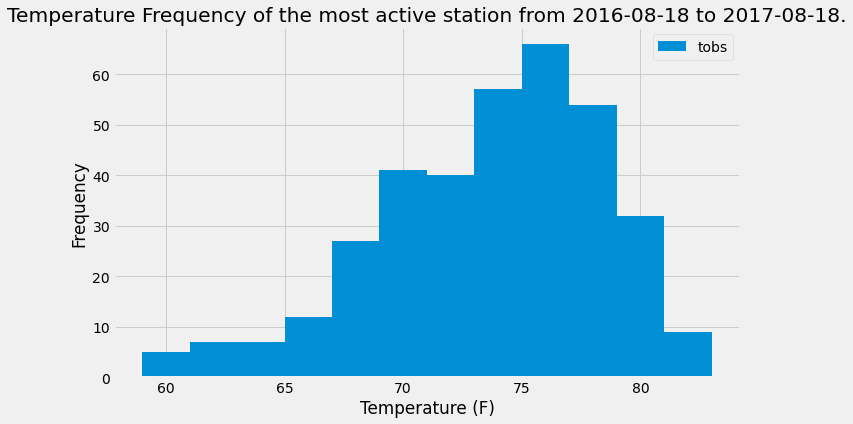

In [20]:
# Plot the result in a histogram
plt.figure(figsize=(10,6))
plt.hist(x=tobs_df["Temperature"], bins=12, label="tobs")
plt.title(f"Temperature Frequency of the most active station from {tobs_querydate} to {tobs_recent[0]}.")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Close session

In [31]:
# Close Session
session.close()